In [143]:
# Uncomment and run the code below to run this notebook in Colab
#
# from os import chdir as cd
# ! git clone https://github.com/edsonportosilva/OpticCommpy-public
# cd('/content/OpticCommpy-public')
# !pip install .
# !pip install numba --upgrade

In [144]:
import matplotlib.pyplot as plt
import numpy as np

from commpy.modulation import QAMModem

from optic.dsp import pulseShape, firFilter, edc, decimate, symbolSync #, fourthPowerFOE, dbp, cpr
from optic.models import phaseNoise, pdmCoherentReceiver#, manakovSSF
from optic.carrierRecovery import cpr
from optic.tx import simpleWDMTx
from optic.core import parameters
from optic.metrics import fastBERcalc, monteCarloGMI, monteCarloMI, signal_power

import scipy.constants as const

In [145]:
from IPython.core.display import HTML
from IPython.core.pylabtools import figsize

HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [146]:
%matplotlib inline
#figsize(7, 2.5)
figsize(10, 3)

In [147]:
%load_ext autoreload
%autoreload 2
#%load_ext line_profiler

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Simulation of coherent transmission


## Transmitter

**Polarization multiplexed signal generation**

In [148]:
# Transmitter parameters:
paramTx = parameters()
paramTx.M   = 64           # order of the modulation format
paramTx.Rs  = 32e9         # symbol rate [baud]
paramTx.SpS = 4            # samples per symbol
paramTx.Nbits = 120000      # total number of bits per polarization
paramTx.pulse = 'rrc'      # pulse shaping filter
paramTx.Ntaps = 1024       # number of pulse shaping filter coefficients
paramTx.alphaRRC = 0.01    # RRC rolloff
paramTx.Pch_dBm = 1        # power per WDM channel [dBm]
paramTx.Nch     = 1        # number of WDM channels
paramTx.Fc      = 193.1e12 # central optical frequency of the WDM spectrum
#paramTx.freqSpac = 37.5e9  # WDM grid spacing
paramTx.Nmodes = 2         # number of signal modes [2 for polarization multiplexed signals]

# generate WDM signal
sigTx, symbTx_, paramTx = simpleWDMTx(paramTx)

channel 0	 fc : 193.1000 THz
  mode #0	 power: -2.01 dBm
  mode #1	 power: -2.01 dBm
channel 0	 power: 1.00 dBm

total WDM signal power: 1.00 dBm


###  coherent detection and demodulation

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 10.00 dBm, lw: 100.00 kHz, FO: 0.00 MHz



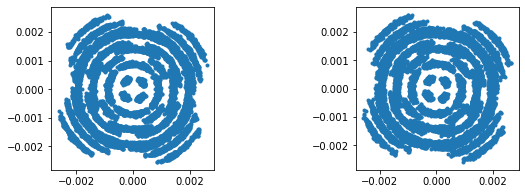

In [149]:
# Receiver

# parameters
chIndex  = 0     # index of the channel to be demodulated
plotPSD  = True

Fc = paramTx.Fc
Ts = 1/(paramTx.SpS*paramTx.Rs)

mod = QAMModem(m=paramTx.M)

freqGrid = paramTx.freqGrid
print('Demodulating channel #%d , fc: %.4f THz, λ: %.4f nm\n'\
      %(chIndex, (Fc + freqGrid[chIndex])/1e12, const.c/(Fc + freqGrid[chIndex])/1e-9))

symbTx = symbTx_[:,:,chIndex]

# local oscillator (LO) parameters:
FO      = 0*64e6                # frequency offset
Δf_lo   = freqGrid[chIndex]+FO  # downshift of the channel to be demodulated
lw      = 100e3                 # linewidth
Plo_dBm = 10                    # power in dBm
Plo     = 10**(Plo_dBm/10)*1e-3 # power in W
ϕ_lo    = 0                     # initial phase in rad    

print('Local oscillator P: %.2f dBm, lw: %.2f kHz, FO: %.2f MHz\n'\
      %(Plo_dBm, lw/1e3, FO/1e6))

# generate LO field
π       = np.pi
t       = np.arange(0, len(sigTx))*Ts
ϕ_pn_lo = phaseNoise(lw, len(sigTx), Ts)
sigLO   = np.sqrt(Plo)*np.exp(1j*(2*π*Δf_lo*t + ϕ_lo + ϕ_pn_lo))

# polarization multiplexed coherent optical receiver
sigRx = pdmCoherentReceiver(sigTx, sigLO, θsig = 0, Rdx=1, Rdy=1)

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot(sigRx[0::paramTx.SpS,0].real, sigRx[0::paramTx.SpS,0].imag,'.')
ax1.axis('square');
ax2.plot(sigRx[0::paramTx.SpS,1].real, sigRx[0::paramTx.SpS,1].imag,'.')
ax2.axis('square');

### Matched filtering

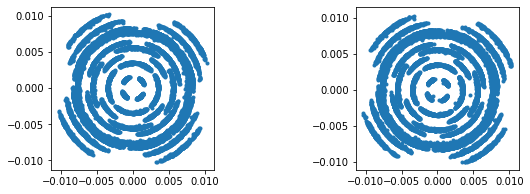

In [150]:
# Rx filtering

# Matched filtering
if paramTx.pulse == 'nrz':
    pulse = pulseShape('nrz', paramTx.SpS)
elif paramTx.pulse == 'rrc':
    pulse = pulseShape('rrc', paramTx.SpS, N=paramTx.Ntaps, alpha=paramTx.alphaRRC, Ts=1/paramTx.Rs)
    
pulse = pulse/np.max(np.abs(pulse))            
sigRx = firFilter(pulse, sigRx)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(sigRx[0::paramTx.SpS,0].real, sigRx[0::paramTx.SpS,0].imag,'.')
ax1.axis('square');
ax2.plot(sigRx[0::paramTx.SpS,1].real, sigRx[0::paramTx.SpS,1].imag,'.')
ax2.axis('square');

### Downsampling to 1 sample/symbol and re-synchronization with transmitted sequences

In [151]:
# decimation
paramDec = parameters()
paramDec.SpS_in  = paramTx.SpS
paramDec.SpS_out = 1
sigRx = decimate(sigRx, paramDec)

symbRx = symbolSync(sigRx, symbTx, 1)

### Power normalization

In [152]:
x = sigRx
d = symbRx

sigRx = sigRx.reshape(len(sigRx),2)/np.sqrt(signal_power(sigRx))
d = d.reshape(len(d),2)/np.sqrt(signal_power(d))

### Carrier phase recovery

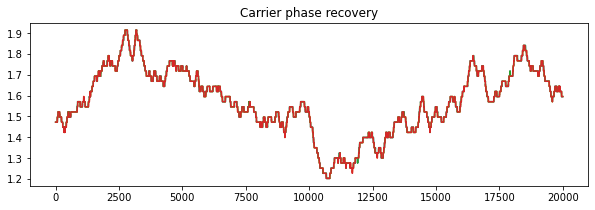

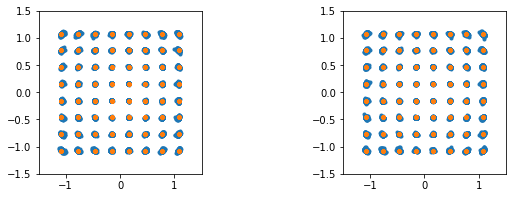

In [164]:
paramCPR = parameters()
paramCPR.alg = 'bps'
paramCPR.M   = paramTx.M
paramCPR.N   = 35
paramCPR.B   = 64
paramCPR.pilotInd = np.arange(0, len(sigRx), 20)
       
y_CPR, ϕ, θ = cpr(sigRx, symbTx=d, param=paramCPR)

y_CPR = y_CPR/np.sqrt(signal_power(y_CPR))

plt.figure()
plt.title('Carrier phase recovery')
plt.plot(ϕ,'-.', θ,'-');


fig, (ax1, ax2) = plt.subplots(1, 2)
discard = 1000

ax1.plot(y_CPR[discard:-discard,0].real, y_CPR[discard:-discard,0].imag,'.')
ax1.plot(d[:,0].real, d[:,0].imag,'.')
ax1.axis('square')
ax1.set_xlim(-1.5, 1.5)
ax1.set_ylim(-1.5, 1.5)

ax2.plot(y_CPR[discard:-discard,1].real, y_CPR[discard:-discard,1].imag,'.')
ax2.plot(d[:,1].real, d[:,1].imag,'.')
ax2.axis('square')
ax2.set_xlim(-1.5, 1.5)
ax2.set_ylim(-1.5, 1.5);

### Evaluate performance metrics

In [163]:
# correct (possible) phase ambiguity
for k in range(y_CPR.shape[1]):
    rot = np.mean(d[:,k]/y_CPR[:,k])
    y_CPR[:,k] = rot*y_CPR[:,k]

#y_CPR = y_CPR/np.sqrt(signal_power(y_CPR))

ind = np.arange(discard, d.shape[0]-discard)
BER, SER, SNR = fastBERcalc(y_CPR[ind,:], d[ind,:], mod)
GMI,_    = monteCarloGMI(y_CPR[ind,:], d[ind,:], mod)
MI       = monteCarloMI(y_CPR[ind,:], d[ind,:], mod)

print('     pol.X     pol.Y      ')
print('SER: %.2e, %.2e'%(SER[0], SER[1]))
print('BER: %.2e, %.2e'%(BER[0], BER[1]))
print('SNR: %.2f dB, %.2f dB'%(SNR[0], SNR[1]))
print('MI: %.2f bits, %.2f bits'%(MI[0], MI[1]))
print('GMI: %.2f bits, %.2f bits'%(GMI[0], GMI[1]))

     pol.X     pol.Y      
SER: 0.00e+00, 0.00e+00
BER: 0.00e+00, 0.00e+00
SNR: 34.67 dB, 34.69 dB
MI: 6.01 bits, 6.01 bits
GMI: 6.00 bits, 6.00 bits
